In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
from scipy import stats as scs
import matplotlib.pyplot as plt


Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

filename_save_out=''
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    
    # number of unique drivers
    driver_num=rho.shape[0]
    # initialize loss for out-of-sample
    Losses_out=np.zeros((Nout,K))

    for s in range(1, Nout + 1):

        # Calculated out-of-sample losses (100000 x 100)
        # generate distribution for y
        norm_dist=np.random.randn(driver_num,1)
        y=np.dot(sqrt_rho,norm_dist)
        # generate distribution for z
        z=np.random.randn(K,1)
        # calcualte the loss for each counterparty j
        # initialize loss
        loss=np.zeros((1,K))
        for j in range(1,K+1):
            # get the driver for counterparty j
            driver_j=int(driver[j-1])
            # calculate w_j
            w_j=beta[j-1]*y[driver_j-1]+np.sqrt(1-beta[j-1]**2)*z[j-1]
            # get the boundry for counterparty j
            CS_Bdry_j=CS_Bdry[j-1]
            # find where does w_j locate
            if w_j < min(CS_Bdry_j):
                w_j_index=-1
            else:
                w_j_index=np.where(w_j > CS_Bdry_j)[0][-1]
            # get the exposure 
            exposure_j=exposure[j-1,w_j_index+1]
            loss[0,j-1]=exposure_j
        # Losses_out (sparse matrix)
        Losses_out[s-1,:]=loss

# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # get the sorted portfolio loss
        sorted_loss=np.sort(np.dot(Losses_out,x0[portN]))
        VaRout[portN, q] = sorted_loss[int(math.ceil(Nout*alf))-1]
        VaRinN[portN, q] = np.mean(sorted_loss)+scs.norm.ppf(alf)*np.std(sorted_loss)
        CVaRout[portN, q] = (1/(Nout*(1-alf)))*((math.ceil(Nout*alf)-Nout*alf)*VaRout[portN,q]+sum(sorted_loss[int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(sorted_loss) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * np.std(sorted_loss)

# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    # initialize in-sample loss
    Losses_inMC1=np.zeros((Nin,K))




    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # generate distribution for y
        norm_dist=np.random.randn(driver_num,1)
        y=np.dot(sqrt_rho,norm_dist)


        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic

            # generate distributio for z
            z=np.random.randn(K,1)
            # Calculate losses for MC1 approximation (5000 x 100)
            # initialize loss
            loss=np.zeros((1,K))
            # calcualte the loss for each counterparty j
            for j in range(1,K+1):
                # get the driver for counterparty j
                driver_j=int(driver[j-1])
                # calculate w_j
                w_j=beta[j-1]*y[driver_j-1]+np.sqrt(1-beta[j-1]**2)*z[j-1]
                # get the boundry for counterparty j
                CS_Bdry_j=CS_Bdry[j-1]
                # find where does w_j locate
                if w_j < min(CS_Bdry_j):
                    w_j_index=-1
                else:
                    w_j_index=np.where(w_j > CS_Bdry_j)[0][-1]
                # get the exposure 
                exposure_j=exposure[j-1,w_j_index+1]
                loss[0,j-1]=exposure_j
            # Losses_inMC1
            Losses_inMC1[(s-1)*Ns+si-1,:]=loss


    # Monte Carlo approximation 2


    # initialize in-sample loss
    Losses_inMC2=np.zeros((Nin,K))


    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)

        # generate distribution for y
        norm_dist=np.random.randn(driver_num,1)
        y=np.dot(sqrt_rho,norm_dist)
        # generate distributio for z
        z=np.random.randn(K,1)
        # initialize loss
        loss=np.zeros((1,K))
        for j in range(1,K+1):
            # get the driver for counterparty j
            driver_j=int(driver[j-1])
            # calculate w_j
            w_j=beta[j-1]*y[driver_j-1]+np.sqrt(1-beta[j-1]**2)*z[j-1]
            # get the boundry for counterparty j
            CS_Bdry_j=CS_Bdry[j-1]
            # find where does w_j locate
            if w_j < min(CS_Bdry_j):
                w_j_index=-1
            else:
                w_j_index=np.where(w_j > CS_Bdry_j)[0][-1]
            # get the exposure 
            exposure_j=exposure[j-1,w_j_index+1]
            loss[0,j-1]=exposure_j
        # Calculated losses for MC2 approximation (5000 x 100)
        # Losses_inMC2
        Losses_inMC2[s-1,:]=loss



    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2

# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 

Portfolio 1:

Out-of-sample: VaR 99.0% = $37459331.28, CVaR 99.0% = $44907881.39
In-sample MC1: VaR 99.0% = $36820905.94, CVaR 99.0% = $43950381.16
In-sample MC2: VaR 99.0% = $37083686.86, CVaR 99.0% = $44683668.55
In-sample No: VaR 99.0% = $26204013.16, CVaR 99.0% = $29097507.68
In-sample N1: VaR 99.0% = $25957682.62, CVaR 99.0% = $28819099.52
In-sample N2: VaR 99.0% = $26177992.20, CVaR 99.0% = $29065430.39

Out-of-sample: VaR 99.9% = $54546390.66, CVaR 99.9% = $60747334.95
In-sample MC1: VaR 99.9% = $52744161.58, CVaR 99.9% = $59323384.65
In-sample MC2: VaR 99.9% = $53961827.96, CVaR 99.9% = $61867336.20
In-sample No: VaR 99.9% = $32726630.24, CVaR 99.9% = $35090649.13
In-sample N1: VaR 99.9% = $32407989.20, CVaR 99.

Text(0.5, 1.0, 'Portfolio 1, out-of-sample scenarios')

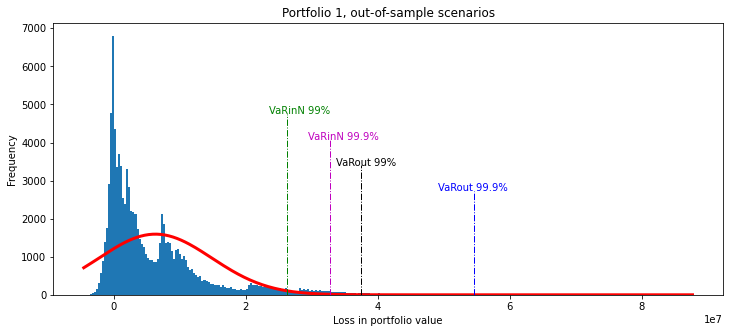

In [ ]:
# Plot results
# Figure (1):
# portfolio 1, out-of-sample
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_out,x0[0]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[0,0], 0.5*max(frequencyCounts), 'VaRout 99%',color='k')
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0,0], 0.7*max(frequencyCounts), 'VaRinN 99%',color='g')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[0,1], 0.4*max(frequencyCounts), 'VaRout 99.9%',color='b')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[0,1], 0.6*max(frequencyCounts), 'VaRinN 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 1, out-of-sample scenarios')

Text(0.5, 1.0, 'Portfolio 1, in-sample MC1 scenarios')

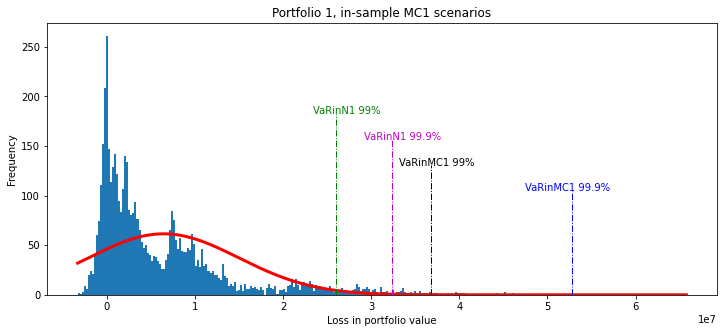

In [ ]:
# portfolio 1, in-sample MC1
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_inMC1,x0[0]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0])], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[0,0]), 0.5*max(frequencyCounts), 'VaRinMC1 99%',color='k')
plt.plot([np.mean(VaRinN1[0,0]), np.mean(VaRinN1[0,0])], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[0,0]), 0.7*max(frequencyCounts), 'VaRinN1 99%',color='g')
plt.plot([np.mean(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1])], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[0,1]), 0.4*max(frequencyCounts), 'VaRinMC1 99.9%',color='b')
plt.plot([np.mean(VaRinN1[0,1]), np.mean(VaRinN1[0,1])], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[0,1]), 0.6*max(frequencyCounts), 'VaRinN1 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 1, in-sample MC1 scenarios')

Text(0.5, 1.0, 'Portfolio 1, in-sample MC2 scenarios')

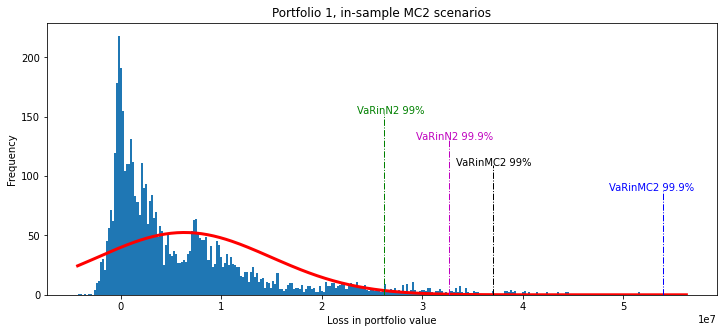

In [ ]:
# portfolio 1, in-sample MC2
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_inMC2,x0[0]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0])], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[0,0]), 0.5*max(frequencyCounts), 'VaRinMC2 99%',color='k')
plt.plot([np.mean(VaRinN2[0,0]), np.mean(VaRinN2[0,0])], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[0,0]), 0.7*max(frequencyCounts), 'VaRinN2 99%',color='g')
plt.plot([np.mean(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1])], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[0,1]), 0.4*max(frequencyCounts), 'VaRinMC2 99.9%',color='b')
plt.plot([np.mean(VaRinN2[0,1]), np.mean(VaRinN2[0,1])], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[0,1]), 0.6*max(frequencyCounts), 'VaRinN2 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 1, in-sample MC2 scenarios')

Text(0.5, 1.0, 'Portfolio 2, out-of-sample scenarios')

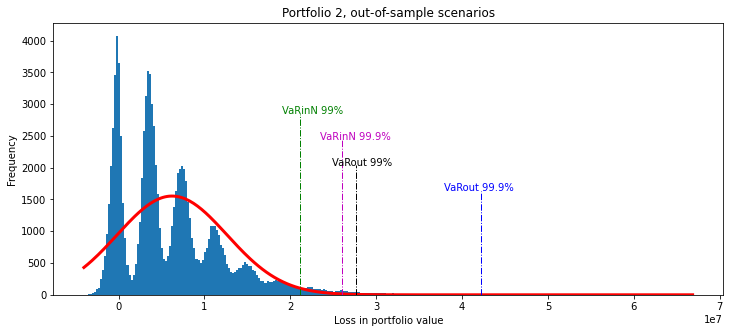

In [ ]:
# portfolio 2, out-of-sample
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_out,x0[1]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([VaRout[1,0], VaRout[1,0]], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[1,0], 0.5*max(frequencyCounts), 'VaRout 99%',color='k')
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1,0], 0.7*max(frequencyCounts), 'VaRinN 99%',color='g')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRout[1,1], 0.4*max(frequencyCounts), 'VaRout 99.9%',color='b')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * VaRinN[1,1], 0.6*max(frequencyCounts), 'VaRinN 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 2, out-of-sample scenarios')

Text(0.5, 1.0, 'Portfolio 2, in-sample MC1 scenarios')

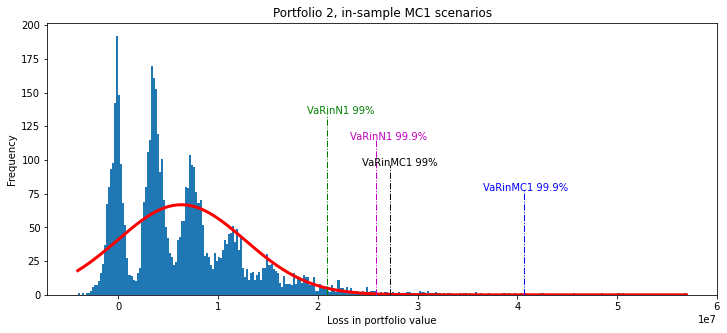

In [ ]:
# portfolio 2, in-sample MC1
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_inMC1,x0[1]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0])], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[1,0]), 0.5*max(frequencyCounts), 'VaRinMC1 99%',color='k')
plt.plot([np.mean(VaRinN1[1,0]), np.mean(VaRinN1[1,0])], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[1,0]), 0.7*max(frequencyCounts), 'VaRinN1 99%',color='g')
plt.plot([np.mean(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1])], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC1[1,1]), 0.4*max(frequencyCounts), 'VaRinMC1 99.9%',color='b')
plt.plot([np.mean(VaRinN1[1,1]), np.mean(VaRinN1[1,1])], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN1[1,1]), 0.6*max(frequencyCounts), 'VaRinN1 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 2, in-sample MC1 scenarios')

Text(0.5, 1.0, 'Portfolio 2, in-sample MC2 scenarios')

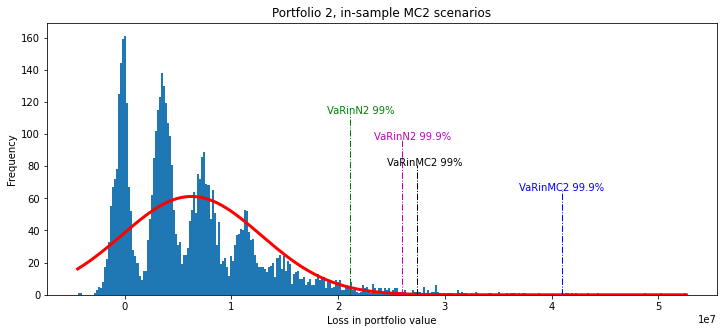

In [ ]:
# portfolio 2, in-sample MC2
plt.figure(figsize=(12,5))
sorted_loss=np.sort(np.dot(Losses_inMC2,x0[1]))
frequencyCounts, binLocations, patches = plt.hist(sorted_loss, 300)
normf= (1 / (np.std(sorted_loss) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations-np.mean(sorted_loss)) / np.std(sorted_loss)) ** 2)
normf= normf* sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
plt.plot([np.mean(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0])], [0, 0.5*max(frequencyCounts)], color='k', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[1,0]), 0.5*max(frequencyCounts), 'VaRinMC2 99%',color='k')
plt.plot([np.mean(VaRinN2[1,0]), np.mean(VaRinN2[1,0])], [0, 0.7*max(frequencyCounts)], color='g', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[1,0]), 0.7*max(frequencyCounts), 'VaRinN2 99%',color='g')
plt.plot([np.mean(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1])], [0, 0.4*max(frequencyCounts)], color='b', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinMC2[1,1]), 0.4*max(frequencyCounts), 'VaRinMC2 99.9%',color='b')
plt.plot([np.mean(VaRinN2[1,1]), np.mean(VaRinN2[1,1])], [0, 0.6*max(frequencyCounts)], color='m', linewidth=1, linestyle='-.')
plt.text(0.9 * np.mean(VaRinN2[1,1]), 0.6*max(frequencyCounts), 'VaRinN2 99.9%',color='m')

plt.xlabel('Loss in portfolio value')
plt.ylabel('Frequency')
plt.title('Portfolio 2, in-sample MC2 scenarios')

Text(0.5, 1.0, 'Difference in VaR for portfolio 1')

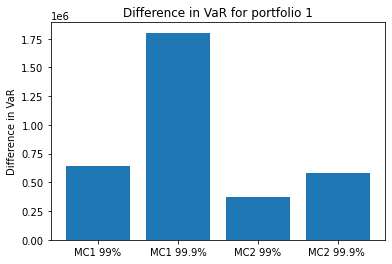

In [ ]:
# difference in VaR for portfolio 1
var_difference=[]
# for MC1
var_difference.append(VaRout[0,0]-np.mean(VaRinMC1[0,0]))
var_difference.append(VaRout[0,1]-np.mean(VaRinMC1[0,1]))
# for MC2
var_difference.append(VaRout[0,0]-np.mean(VaRinMC2[0,0]))
var_difference.append(VaRout[0,1]-np.mean(VaRinMC2[0,1]))
# plot the difference
plt.figure()
plt.bar(height=var_difference,x=['MC1 99%','MC1 99.9%','MC2 99%','MC2 99.9% '])
plt.ylabel('Difference in VaR')
plt.title('Difference in VaR for portfolio 1')

Text(0.5, 1.0, 'Difference in CVaR for portfolio 1')

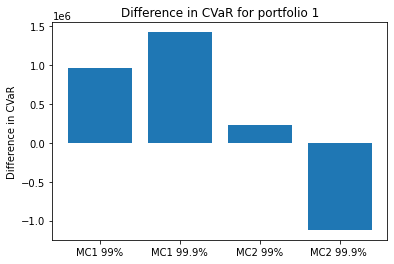

In [ ]:
# difference in CVaR for portfolio 1
cvar_difference=[]
# for MC1
cvar_difference.append(CVaRout[0,0]-np.mean(CVaRinMC1[0,0]))
cvar_difference.append(CVaRout[0,1]-np.mean(CVaRinMC1[0,1]))
# for MC2
cvar_difference.append(CVaRout[0,0]-np.mean(CVaRinMC2[0,0]))
cvar_difference.append(CVaRout[0,1]-np.mean(CVaRinMC2[0,1]))
# plot the difference
plt.figure()
plt.bar(height=cvar_difference,x=['MC1 99%','MC1 99.9%','MC2 99%','MC2 99.9% '])
plt.ylabel('Difference in CVaR')
plt.title('Difference in CVaR for portfolio 1')

Text(0.5, 1.0, 'Difference in VaR for portfolio 2')

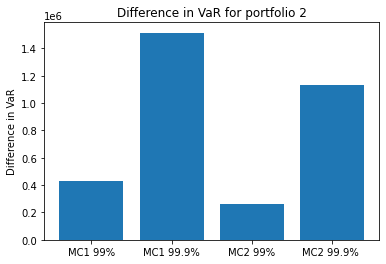

In [ ]:
# difference in VaR for portfolio 2
var_difference=[]
# for MC1
var_difference.append(VaRout[1,0]-np.mean(VaRinMC1[1,0]))
var_difference.append(VaRout[1,1]-np.mean(VaRinMC1[1,1]))
# for MC2
var_difference.append(VaRout[1,0]-np.mean(VaRinMC2[1,0]))
var_difference.append(VaRout[1,1]-np.mean(VaRinMC2[1,1]))
# plot the difference
plt.figure()
plt.bar(height=var_difference,x=['MC1 99%','MC1 99.9%','MC2 99%','MC2 99.9% '])
plt.ylabel('Difference in VaR')
plt.title('Difference in VaR for portfolio 2')

Text(0.5, 1.0, 'Difference in CVaR for portfolio 2')

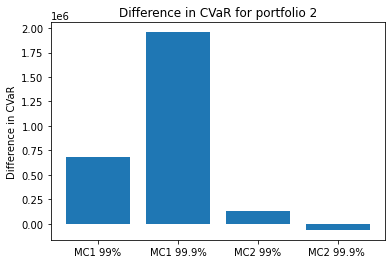

In [ ]:
# difference in CVaR for portfolio 2
cvar_difference=[]
# for MC1
cvar_difference.append(CVaRout[1,0]-np.mean(CVaRinMC1[1,0]))
cvar_difference.append(CVaRout[1,1]-np.mean(CVaRinMC1[1,1]))
# for MC2
cvar_difference.append(CVaRout[1,0]-np.mean(CVaRinMC2[1,0]))
cvar_difference.append(CVaRout[1,1]-np.mean(CVaRinMC2[1,1]))
# plot the difference
plt.figure()
plt.bar(height=cvar_difference,x=['MC1 99%','MC1 99.9%','MC2 99%','MC2 99.9% '])
plt.ylabel('Difference in CVaR')
plt.title('Difference in CVaR for portfolio 2')

In [ ]:
# VaR standard deviation of 100 trials for MC1
# std for portfolio 1, alpha = 99%
var_std_1=np.std(VaRinMC1[0,0])
# std for portfolio 1, alpha = 99.9%
var_std_2=np.std(VaRinMC1[0,1])
# std for portfolio 2, alpha = 99%
var_std_3=np.std(VaRinMC1[1,0])
# std for portfolio 2, alpha = 99.9%
var_std_4=np.std(VaRinMC1[1,1])
print('Standard deviation for VaR in MC1:')
print('portfolio 1, alpha =99%: {}'.format(var_std_1))
print('portfolio 1, alpha =99.9%: {}'.format(var_std_2))
print('portfolio 2, alpha =99%: {}'.format(var_std_3))
print('portfolio 2, alpha =99.9%: {}'.format(var_std_4))

Standard deviation for VaR in MC1:
portfolio 1, alpha =99%: 1329313.201636966
portfolio 1, alpha =99.9%: 4373458.1984134065
portfolio 2, alpha =99%: 1303131.2347761765
portfolio 2, alpha =99.9%: 4960290.035034982


In [ ]:
# CVaR standard deviation of 100 trials for MC1
# std for portfolio 1, alpha = 99%
cvar_std_1=np.std(CVaRinMC1[0,0])
# std for portfolio 1, alpha = 99.9%
cvar_std_2=np.std(CVaRinMC1[0,1])
# std for portfolio 2, alpha = 99%
cvar_std_3=np.std(CVaRinMC1[1,0])
# std for portfolio 2, alpha = 99.9%
cvar_std_4=np.std(CVaRinMC1[1,1])
print('Standard deviation for CVaR in MC1:')
print('portfolio 1, alpha =99%: {}'.format(cvar_std_1))
print('portfolio 1, alpha =99.9%: {}'.format(cvar_std_2))
print('portfolio 2, alpha =99%: {}'.format(cvar_std_3))
print('portfolio 2, alpha =99.9%: {}'.format(cvar_std_4))

Standard deviation for CVaR in MC1:
portfolio 1, alpha =99%: 2260113.422353055
portfolio 1, alpha =99.9%: 6112442.960133648
portfolio 2, alpha =99%: 2161286.083277956
portfolio 2, alpha =99.9%: 6022669.716843762


In [ ]:
# VaR standard deviation of 100 trials for MC2
# std for portfolio 1, alpha = 99%
var_std_1=np.std(VaRinMC2[0,0])
# std for portfolio 1, alpha = 99.9%
var_std_2=np.std(VaRinMC2[0,1])
# std for portfolio 2, alpha = 99%
var_std_3=np.std(VaRinMC2[1,0])
# std for portfolio 2, alpha = 99.9%
var_std_4=np.std(VaRinMC2[1,1])
print('Standard deviation for VaR in MC2:')
print('portfolio 1, alpha =99%: {}'.format(var_std_1))
print('portfolio 1, alpha =99.9%: {}'.format(var_std_2))
print('portfolio 2, alpha =99%: {}'.format(var_std_3))
print('portfolio 2, alpha =99.9%: {}'.format(var_std_4))

Standard deviation for VaR in MC2:
portfolio 1, alpha =99%: 1119587.4714043841
portfolio 1, alpha =99.9%: 3615088.299248605
portfolio 2, alpha =99%: 752808.3621758242
portfolio 2, alpha =99.9%: 2520759.2464474235


In [ ]:
# CVaR standard deviation of 100 trials for MC2
# std for portfolio 1, alpha = 99%
cvar_std_1=np.std(CVaRinMC2[0,0])
# std for portfolio 1, alpha = 99.9%
cvar_std_2=np.std(CVaRinMC2[0,1])
# std for portfolio 2, alpha = 99%
cvar_std_3=np.std(CVaRinMC2[1,0])
# std for portfolio 2, alpha = 99.9%
cvar_std_4=np.std(CVaRinMC2[1,1])
print('Standard deviation for CVaR in MC2:')
print('portfolio 1, alpha =99%: {}'.format(cvar_std_1))
print('portfolio 1, alpha =99.9%: {}'.format(cvar_std_2))
print('portfolio 2, alpha =99%: {}'.format(cvar_std_3))
print('portfolio 2, alpha =99.9%: {}'.format(cvar_std_4))

Standard deviation for CVaR in MC2:
portfolio 1, alpha =99%: 1531526.6031435046
portfolio 1, alpha =99.9%: 5722782.566170189
portfolio 2, alpha =99%: 1150492.9708867997
portfolio 2, alpha =99.9%: 4183815.087311371
